# AI-Powered Sentiment Analysis
## Using Pre-trained Transformer Models (BERT)

**Purpose**: Analyze sentiment of news articles and social posts using state-of-the-art NLP

In [ ]:
# Setup
import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from pipeline.models.database import Database

print("Libraries loaded")

✅ Libraries loaded


In [ ]:
# Load AI Sentiment Model
print("🤖 Loading transformer model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1 
)
print("AI model loaded successfully!")

🤖 Loading transformer model...


Device set to use cpu


✅ AI model loaded successfully!


In [ ]:
# Load ALL Data from Database
db = Database()
db.connect()

# check total records
with db.get_cursor(dict_cursor=True) as cursor:
    cursor.execute("SELECT COUNT(*) as total FROM raw_data")
    total = cursor.fetchone()['total']
    print(f"Total records in database: {total:,}")

# Load ALL records
print("Loading all records...")
with db.get_cursor(dict_cursor=True) as cursor:
    cursor.execute("""
        SELECT id, source, title, snippet, source_type, fetched_at
        FROM raw_data
        ORDER BY fetched_at DESC
    """)
    data = cursor.fetchall()

df = pd.DataFrame(data)
print(f"Loaded {len(df):,} records for AI analysis")
print(f"\nSources: {df['source'].value_counts().to_dict()}")
print(f"Types: {df['source_type'].value_counts().to_dict()}")
df.head()

✅ Connected to PostgreSQL
📊 Total records in database: 7,636
🔄 Loading all records...
✅ Loaded 7,636 records for AI analysis

Sources: {'X (Twitter) [Simulated]': 7470, 'Ada Derana': 99, 'The Island': 67}
Types: {'social': 7470, 'news': 166}


,id,source,title,snippet,source_type,fetched_at
0,11027,X (Twitter) [Simulated],Citizens voicing concerns #LKA,Citizens voicing concerns #LKA,social,2025-12-03 15:40:34.497664
1,11031,X (Twitter) [Simulated],Discussing road conditions in Sri Lanka #LKA,Discussing road conditions in Sri Lanka #LKA,social,2025-12-03 15:40:34.497664
2,11011,X (Twitter) [Simulated],Discussing government policy in Sri Lanka #LKA,Discussing government policy in Sri Lanka #LKA,social,2025-12-03 15:40:34.497664
3,11012,X (Twitter) [Simulated],Citizens voicing concerns #LKA,Citizens voicing concerns #LKA,social,2025-12-03 15:40:34.497664
4,11013,X (Twitter) [Simulated],Discussing public transport in Sri Lanka #LKA,Discussing public transport in Sri Lanka #LKA,social,2025-12-03 15:40:34.497664


In [ ]:
# Prepare Text for Analysis
df['text'] = df['title'] + ' ' + df['snippet'].fillna('')
df['text'] = df['text'].str[:512]  # Truncate to model limit

print("Text prepared for AI analysis")

✅ Text prepared for AI analysis


In [ ]:
# Run AI Sentiment Analysis
print(f"🤖 Running AI sentiment analysis on {len(df):,} records...")
print("⏱️  Estimated time: ~{} minutes".format(int(len(df) / 200)))

results = []
batch_size = 32 
failed = 0

for i in range(0, len(df), batch_size):
    batch = df['text'].iloc[i:i+batch_size].tolist()
    
    try:
        batch_results = sentiment_analyzer(batch)
        results.extend(batch_results)
    except Exception as e:
        # If batch fails, process individually
        print(f"Batch {i//batch_size} failed, processing individually...")
        for text in batch:
            try:
                results.append(sentiment_analyzer(text)[0])
            except:
                results.append({'label': 'NEUTRAL', 'score': 0.5})
                failed += 1
    
    # Progress indicator
    if (i // batch_size) % 25 == 0:
        progress = (i / len(df)) * 100
        print(f"  Progress: {progress:.1f}% ({i:,}/{len(df):,} records)")

print(f"AI analysis complete!")
print(f"   Processed: {len(results):,} records")
print(f"   Failed: {failed} records")

🤖 Running AI sentiment analysis on 7,636 records...
⏱️  Estimated time: ~38 minutes
  Progress: 0.0% (0/7,636 records)
  Progress: 10.5% (800/7,636 records)
  Progress: 21.0% (1,600/7,636 records)
  Progress: 31.4% (2,400/7,636 records)
  Progress: 41.9% (3,200/7,636 records)
  Progress: 52.4% (4,000/7,636 records)
  Progress: 62.9% (4,800/7,636 records)
  Progress: 73.3% (5,600/7,636 records)
  Progress: 83.8% (6,400/7,636 records)
  Progress: 94.3% (7,200/7,636 records)
✅ AI analysis complete!
   Processed: 7,636 records
   Failed: 0 records


In [ ]:
# Add AI Results to DataFrame
df['ai_sentiment'] = [r['label'] for r in results]
df['ai_confidence'] = [r['score'] for r in results]
df['ai_sentiment_score'] = df.apply(
    lambda x: x['ai_confidence'] if x['ai_sentiment'] == 'POSITIVE' else -x['ai_confidence'],
    axis=1
)

print("AI sentiment scores added")
df[['source', 'title', 'ai_sentiment', 'ai_confidence']].head(10)

✅ AI sentiment scores added


,source,title,ai_sentiment,ai_confidence
0,X (Twitter) [Simulated],Citizens voicing concerns #LKA,NEGATIVE,0.932809
1,X (Twitter) [Simulated],Discussing road conditions in Sri Lanka #LKA,POSITIVE,0.967368
2,X (Twitter) [Simulated],Discussing government policy in Sri Lanka #LKA,POSITIVE,0.972009
3,X (Twitter) [Simulated],Citizens voicing concerns #LKA,NEGATIVE,0.932809
4,X (Twitter) [Simulated],Discussing public transport in Sri Lanka #LKA,POSITIVE,0.973319
5,X (Twitter) [Simulated],Heavy rains expected ☔ #SriLanka #Weather,NEGATIVE,0.889407
6,X (Twitter) [Simulated],Discussing government policy in Sri Lanka #LKA,POSITIVE,0.972009
7,X (Twitter) [Simulated],Discussing road conditions in Sri Lanka #LKA,POSITIVE,0.967368
8,X (Twitter) [Simulated],Flood warnings issued #LKA,NEGATIVE,0.973242
9,X (Twitter) [Simulated],Discussing tech startup in Sri Lanka #LKA,POSITIVE,0.978037


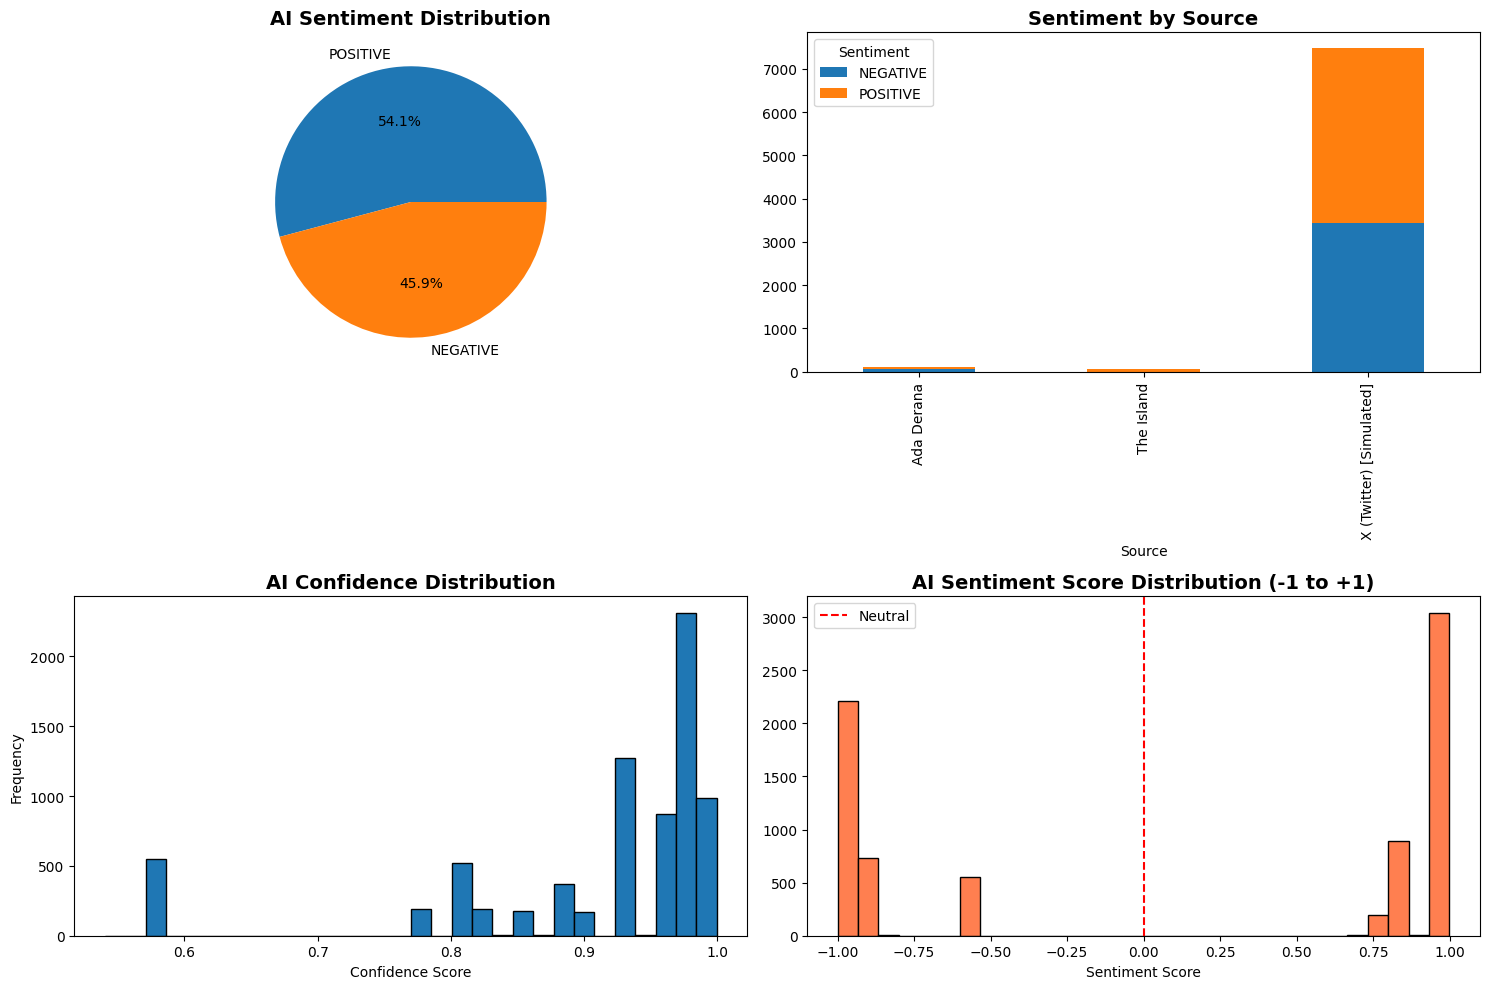

✅ Visualization saved!


In [ ]:
# Visualize AI Sentiment Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Overall Sentiment Distribution
sentiment_counts = df['ai_sentiment'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('AI Sentiment Distribution', fontsize=14, fontweight='bold')

# 2. Sentiment by Source
sentiment_by_source = pd.crosstab(df['source'], df['ai_sentiment'])
sentiment_by_source.plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Sentiment by Source', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Source')
axes[0, 1].legend(title='Sentiment')

# 3. Confidence Score Distribution
axes[1, 0].hist(df['ai_confidence'], bins=30, edgecolor='black')
axes[1, 0].set_title('AI Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')

# 4. Sentiment Score Distribution
axes[1, 1].hist(df['ai_sentiment_score'], bins=30, edgecolor='black', color='coral')
axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Neutral')
axes[1, 1].set_title('AI Sentiment Score Distribution (-1 to +1)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('ai_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved!")

In [ ]:
# AI Insights Summary
print("="*70)
print("🤖 AI SENTIMENT ANALYSIS SUMMARY")
print("="*70)

avg_sentiment = df['ai_sentiment_score'].mean()
print(f"\n📊 Overall Sentiment Score: {avg_sentiment:.3f}")

if avg_sentiment < -0.3:
    mood = "Very Negative"
elif avg_sentiment < -0.1:
    mood = "Negative"
elif avg_sentiment < 0.1:
    mood = "Neutral"
elif avg_sentiment < 0.3:
    mood = "Positive"
else:
    mood = "Very Positive"

print(f"Public Mood: {mood}\n")

print("Distribution:")
for sentiment, count in df['ai_sentiment'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"  {sentiment}: {count} ({pct:.1f}%)")

print(f"\nAverage AI Confidence: {df['ai_confidence'].mean():.3f}")
print("="*70)

🤖 AI SENTIMENT ANALYSIS SUMMARY

📊 Overall Sentiment Score: 0.100
Public Mood: 🟡 Neutral

Distribution:
  POSITIVE: 4134 (54.1%)
  NEGATIVE: 3502 (45.9%)

Average AI Confidence: 0.912


In [ ]:
# Save AI Results to Database
print("💾 Saving AI sentiment scores to database...")

with db.get_cursor() as cursor:
    for _, row in df.iterrows():
        cursor.execute("""
            UPDATE raw_data
            SET metadata = COALESCE(metadata, '{}'::jsonb) ||
                          jsonb_build_object(
                              'ai_sentiment', %s,
                              'ai_confidence', %s,
                              'ai_sentiment_score', %s
                          )
            WHERE id = %s
        """, (
            row['ai_sentiment'],
            float(row['ai_confidence']),
            float(row['ai_sentiment_score']),
            row['id']
        ))

print("AI sentiment scores saved to database!")
db.disconnect()

💾 Saving AI sentiment scores to database...
✅ AI sentiment scores saved to database!
👋 Disconnected from PostgreSQL


In [ ]:
# Export for Dashboard
df[['source', 'title', 'ai_sentiment', 'ai_confidence', 'ai_sentiment_score']].to_csv(
    'ai_sentiment_results.csv',
    index=False
)
print("Results exported to CSV for dashboard!")

✅ Results exported to CSV for dashboard!
